# base_linear

> API needed for linear evaluation protocol
 





In [ ]:
#| default_exp base_linear

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import kornia.augmentation as korniatfm
import torchvision.transforms as tvtfm


API:


- Train and then test linear head. Requires inputs: encoder, dls_val, augpipe_val, indim,outdim, num_epochs,

In [ ]:
#| export
#Batch level augmentations for linear classifier. At present time, just RandomResizedCrop and Normalization.
def get_linear_batch_augs(size,resize=True,
                    resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),
                    stats=None,cuda=default_device().type == 'cuda',xtra_tfms=[]):
    
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    if resize:tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]
    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe


The model for linear evaluation is a frozen encoder with a trainable linear head on top:

In [ ]:
#| export
#Linear model 
class LinearModel(Module):
    """Linear model
    """
    def __init__(self,encoder,
                 indim=1024,#dimension of encoder output
                 outdim=10, #number of classes
                ):
        self.encoder=encoder
        self.L = nn.Linear(indim,outdim) 
        
    def forward(self,x):return self.L(self.encoder(x))


The 'callback' for linear evaluation is the following:

In [ ]:
#| export
class LinearBt(Callback):
    order,run_valid = 9,True
    def __init__(self,aug_pipelines,n_in, show_batch=False, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1= aug_pipelines[0]
        self.aug2=Pipeline( split_idx = 0) #empty pipeline
        if print_augs: print(self.aug1), print(self.aug2)
        self.n_in=n_in
        self._show_batch=show_batch
        self.criterion = nn.CrossEntropyLoss()

    def before_fit(self): 
        self.learn.loss_func = self.lf
            
    def before_batch(self):

        if self.n_in == 1:
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))                            
        elif self.n_in == 3:
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (xi,)

        if self._show_batch:
            self.learn.aug_x = torch.cat([xi, xj])

    def lf(self, pred, *yb):        
        loss=self.criterion(pred,self.y)
        return loss

    @torch.no_grad()
    def show(self, n=1):
        if self._show_batch==False:
            print('Need to set show_batch=True')
            return
        bs = self.learn.aug_x.size(0)//2
        x1,x2  = self.learn.aug_x[:bs], self.learn.aug_x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)


In [ ]:
#| export
def grad_model(f,on=False):
    "Turn the gradients of f on or off"
    for p in f.parameters():
        p.requires_grad=on
    return f

Example usage: First inputs needed. In the next cell we get dls_val and dls_test. 

In [ ]:
#| hide

#Inputs needed: First set hps and get dls_val and dls_test
device=default_device().type
cuda=(device=='cuda')
#hps
n_in=3
bs=4
bs_test=4 #Make sure it divides length of test set
size=32

#get the data
path = untar_data(URLs.CIFAR)
fnames = get_image_files(path / "train")
fnames=fnames.shuffle()
def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')

#labels for train,eval and test
labels = [label_func(fname) for fname in fnames]

#Used for training encoder i.e. BT
dls_val = ImageDataLoaders.from_lists(path, fnames[0:1000], labels[0:1000],bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=0,device=device)

dls_test = dls_val = ImageDataLoaders.from_lists(path, fnames[1000:2000], labels[1000:2000],bs=bs_test, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=0,device=device)





set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

Augmentations and learner:

In [ ]:
#| hide
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in) #Need an encoder (this will be trained by BT)
fastai_encoder.eval()
encoder = grad_model(fastai_encoder,on=False)
model = LinearModel(encoder=encoder,indim=1024)
aug_pipelines_val = [get_linear_batch_augs(size=size,stats=cifar_stats,resize_scale=(0.3, 1.0))]
bt = LinearBt(aug_pipelines_val,show_batch=True,n_in=n_in,print_augs=True)
learn = Learner(dls_val,model, cbs=[bt],metrics=accuracy)

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: 


Examine augmentations:

In [ ]:
#| export
def show_linear_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
    bt = LinearBt(aug,show_batch=True,n_in=n_in,print_augs=print_augs)
    learn = Learner(dls,model=None, cbs=[bt])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.linear_bt.show(n=n)
    

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: 


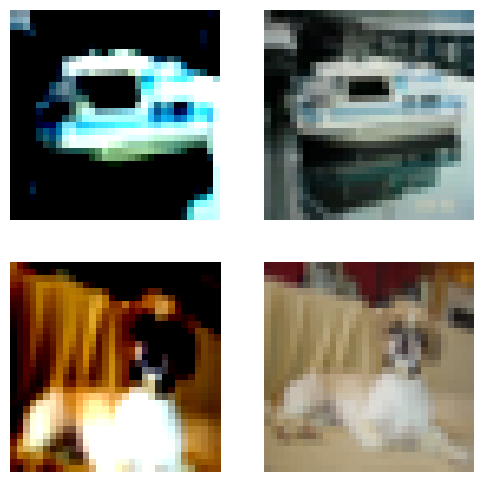

In [ ]:
#| hide
show_linear_batch(dls=dls_val,n_in=n_in,n=2,aug=aug_pipelines_val,print_augs=True)

Fit as usual:

In [ ]:
#| hide
#learn.fit(1)

Now we need to evaluate on test set:

All we need is Main_Linear_Eval in order to map from the inputs (see its init method: need an encoder, aug_pipeline
etc) to accuracy. i.e. this is a wrapper for the whole API

In [ ]:
#| export

#Given validation set, test set, encoder, etc return accuracy via __call__

class Main_Linear_Eval:
    
    def __init__(self,size,n_in,indim,numfit, #size e.g. 32, n_in e.g. 1 or 3, indim  is encoder output dim, numfit number of epochs training 
                 dls_val,dls_test, #dls_val for training linear, dls_test for evaluation
                 stats, #e.g. cifar_stats
                 aug_pipelines_val, #generally simple (crop and normalizatiom)
                 encoder #the encoder
                ):
    
        store_attr()
        self.model = LinearModel(encoder=encoder,indim=indim)
        
    #Use this guy to put the model into evaluation mode
    def Eval_Mode(self,_model):

        aug_pipelines = get_linear_batch_augs(size=self.size,resize=False,stats=self.stats)

        @torch.no_grad()
        def call(x):
            return _model(aug_pipelines(x))

        return call
        
    #Evaluate linear model on dls_test
    def eval_linear(self):

        eval_model = self.Eval_Mode(self.model)
        N=len(self.dls_test.train)*self.dls_test.bs
        test_eq(N,len(self.dls_test.train_ds))

        num_correct=0
        for x,y in self.dls_test.train:

            ypred=eval_model(x) 
            correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
            num_correct += correct.sum()

        accuracy = num_correct/N
        return accuracy.item()
        
        
    def __call__(self):
        
        #train linear classifier on dls_eval. Requires inputs: encoder, aug_pipeline, dls, 
        bt = LinearBt(self.aug_pipelines_val,show_batch=True,n_in=self.n_in,print_augs=False)
        learn = Learner(self.dls_val,self.model, cbs=[bt])
        learn.fit(self.numfit)
        
        #eval linear classifier
        acc = self.eval_linear()
        
        return acc
    

In [ ]:
#| hide

#Main as a function -> But at the moment I think I prefer it as a class; we can setup once, and then modify the encoder
#each time

# def Main_Linear_Eval(n_in, #either 1 or 3 mostly
#                      indim, #Output dimension of encoder
#                      numfit, #Number of epochs to fit linear head
#                      dls_val, #Used to train linear head
#                      dls_test, #Used to evaluate (test) the trained linear head
#                      aug_pipelines_val, #Aug pipeline when training linear head (typically just cropping / normalization)
#                      encoder): #Encoder
    
#     model = LinearModel(encoder=encoder,indim=indim)
#     #train linear classifier on dls_eval. Requires inputs: encoder, aug_pipeline, dls, 
#     bt = LinearBt(aug_pipelines_val,show_batch=True,n_in=n_in,print_augs=False)
#     learn = Learner(dls_val,model, cbs=[bt])
#     learn.fit(numfit)

#     #eval linear classifier
#     acc = eval_linear(model,dls_test)

#     return acc
    

The entire API can be reduced to the following: 

In [ ]:
#| hide

#setup
main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=1,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                        dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                        stats=cifar_stats,
                        aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                        encoder=fastai_encoder #encoder
                                    )
#main_linear_eval.encoder = self.encoder (usage within BT training)
acc=main_linear_eval()
acc

epoch,train_loss,valid_loss,time
0,2.227294,None,00:13


/Users/hamishhaggerty/opt/anaconda3/envs/renamelater/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


0.30000001192092896

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()